In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC


import string
import re
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk import FreqDist
from nltk.tokenize import word_tokenize

# Import Data

In [87]:
items_df = pd.read_csv('csv_files/cleaned_items_df.csv',index_col=0)
items_df.shape

(228, 5)

In [88]:
reviews_df = pd.read_csv('csv_files/cleaned_reviews_df.csv',index_col=0)
reviews_df.shape

(5539, 5)

In [89]:
final_df = pd.read_csv('csv_files/cleaned_items_reviews_df.csv',index_col=0)
final_df.head()

,asin_id,name,price,avg_rating,no_of_ratings,review_id,review_title,review_description,user_rating,cleaned_title,cleaned_reviews
0,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1OSPWS88F2CUZ,DO NOT BUY!!!,I would give this zero stars if I could! If ...,1.0,buy,would give zero stars could youre original sor...
1,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1DCFJ8VYSN17B,Is this the millennial version?,This is not the original sorry game. It only...,1.0,millennial version,original sorry game pawns per team instead tr...
2,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1V07N4GXA7RSL,Wimp and Crybaby Edition,We bought this to replace our old Sorry game...,1.0,wimp crybaby edition,bought replace old sorry game falling apart w...
3,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R2Z262NZDEU2EY,NOT the original/regular Sorry!,Be warned that this is not the sorry you gre...,2.0,originalregular sorry,warned sorry grew three tokens per player rule...
4,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,RG3XIFV1PUX9Y,"Not the classic by a long shot, but okay.","Definitely not the classic game, with only 3...",4.0,classic long shot okay,definitely classic game pawns cards instead d...


In [90]:
final_df['cleaned_reviews'][0]

'would give zero stars could youre original sorry game dont buy version changed rules entirely ruining whole game longer  pawns per person  rather able get   get number oh sorry card allows bump someone back start also option move  places like game created new generation entitled children cant take time finish challenging game right way without throwing fit instant gratification issues wish opened sooner could return diasspointed update'

In [91]:
# drop rows where cleaned_reviews are na
final_df.isna()
final_df = final_df.dropna(subset=['cleaned_reviews'])

# Convert Ratings to Binary Class

In [92]:
final_df['new_rating'] = np.where(final_df['user_rating'] >= 4.0, 'GOOD', 'BAD')

In [93]:
final_df.head()

,asin_id,name,price,avg_rating,no_of_ratings,review_id,review_title,review_description,user_rating,cleaned_title,cleaned_reviews,new_rating
0,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1OSPWS88F2CUZ,DO NOT BUY!!!,I would give this zero stars if I could! If ...,1.0,buy,would give zero stars could youre original sor...,BAD
1,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1DCFJ8VYSN17B,Is this the millennial version?,This is not the original sorry game. It only...,1.0,millennial version,original sorry game pawns per team instead tr...,BAD
2,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1V07N4GXA7RSL,Wimp and Crybaby Edition,We bought this to replace our old Sorry game...,1.0,wimp crybaby edition,bought replace old sorry game falling apart w...,BAD
3,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R2Z262NZDEU2EY,NOT the original/regular Sorry!,Be warned that this is not the sorry you gre...,2.0,originalregular sorry,warned sorry grew three tokens per player rule...,BAD
4,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,RG3XIFV1PUX9Y,"Not the classic by a long shot, but okay.","Definitely not the classic game, with only 3...",4.0,classic long shot okay,definitely classic game pawns cards instead d...,GOOD


# Class Imbalance

In [94]:
final_df['new_rating'].value_counts()

GOOD    4199
BAD     1288
Name: new_rating, dtype: int64

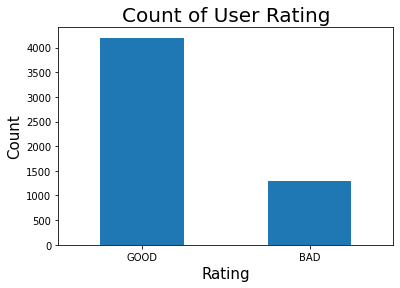

In [95]:
# plt.figure(figsize=(20,10))
final_df['new_rating'].value_counts().plot.bar(rot=0)

plt.title('Count of User Rating',fontsize=20)
plt.xlabel('Rating',fontsize=15)
plt.xticks(fontsize=10)
plt.ylabel('Count',fontsize=15)
plt.yticks(fontsize=10);

It appears we have a class imbalance problem where the number of 5.0 reviews are much greater than the other reviews. Oversampling the minority classes will lead to overfitting due to a creation of large number of synthetic rows. To address this, I will take a set number of random samples from each class.

## Undersampling

In [96]:
def undersampling(dataframe, column, list_user_rating, samples):
    df = pd.DataFrame()
    for rating in list_user_rating:
        sample = dataframe[dataframe[column] == rating].sample(samples)
        df = df.append(sample)
    return df

In [97]:
undersampled_df =undersampling(final_df, 'new_rating', final_df['new_rating'].unique(), 1200)
undersampled_df.shape

(2400, 12)

In [98]:
undersampled_df.head()

,asin_id,name,price,avg_rating,no_of_ratings,review_id,review_title,review_description,user_rating,cleaned_title,cleaned_reviews,new_rating
361,B083YKWBC1,Hasbro Gaming Monopoly: Disney Villains Editio...,29.99,4.4,83,R2ZW89KXV3N4XO,Vehicle cards missing.,My Vehicle cards are missing. Instead I rece...,3.0,vehicle cards missing,vehicle cards missing instead received four bl...,BAD
2034,B000P69H62,Redneck Life Board Game,26.18,4.7,1750,RRZ08B4164B3M,The manufacturer is non-responsive,I've heard lots of great things about this g...,3.0,manufacturer nonresponsive,ive heard lots great things game actually look...,BAD
1371,B086B7QPTB,Ravensburger Marvel Villainous: Infinite Power...,34.99,4.6,507,RIPGP5KWU75OL,Cheaply made and arrived damaged,As an owner or every version of the Villiano...,2.0,cheaply made arrived damaged,owner every version villianous series excited ...,BAD
5359,B016LBWYTQ,Hasbro Gaming Marvel Spider-Man Web Warriors C...,16.99,4.8,1012,R19WMYE3HECJLG,Disappointing and cumbersome,disappointing! Got it for my 5 year old sons...,2.0,disappointing cumbersome,disappointing got year old sons birthday ye...,BAD
2374,B01M3UZGD9,Kids Create Absurdity: Laugh Until You Cry! A ...,19.95,4.6,1019,RB04AVTN08SD3,Boring but easy to learn,This is a copy of the better original versio...,3.0,boring easy learn,copy better original version kids maturity ga...,BAD


In [99]:
undersampled_df['new_rating'].value_counts()

BAD     1200
GOOD    1200
Name: new_rating, dtype: int64

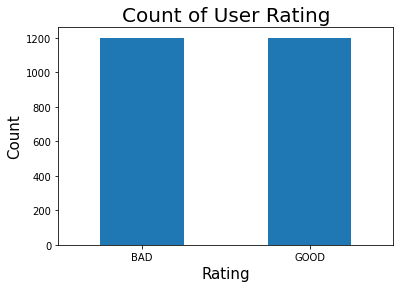

In [100]:
# plt.figure(figsize=(20,10))
undersampled_df['new_rating'].value_counts().plot.bar(rot=0)

plt.title('Count of User Rating',fontsize=20)
plt.xlabel('Rating',fontsize=15)
plt.xticks(fontsize=10)
plt.ylabel('Count',fontsize=15)
plt.yticks(fontsize=10);

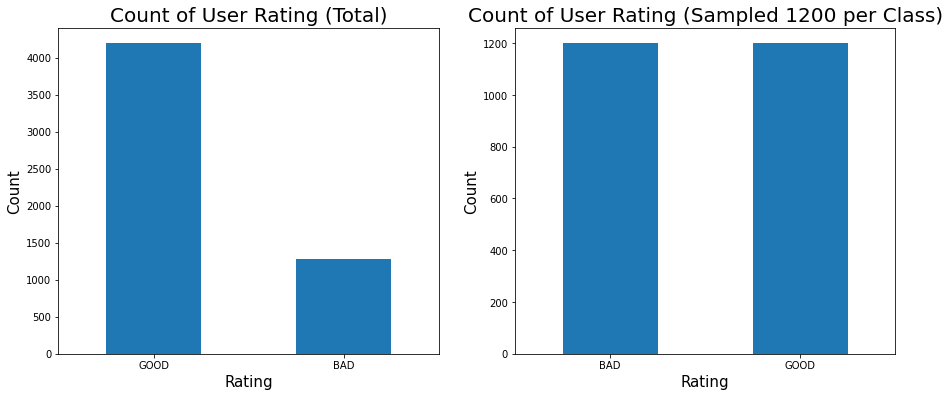

In [101]:
plt.subplot(1,2,1)
final_df['new_rating'].value_counts().plot.bar(rot=0, figsize=(15,6))
plt.title('Count of User Rating (Total)',fontsize=20)
plt.xlabel('Rating',fontsize=15)
plt.xticks(fontsize=10)
plt.ylabel('Count',fontsize=15)
plt.yticks(fontsize=10)

plt.subplot(1,2,2)
undersampled_df['new_rating'].value_counts().plot.bar(rot=0, figsize=(15,6))
plt.title('Count of User Rating (Sampled 1200 per Class)',fontsize=20)
plt.xlabel('Rating',fontsize=15)
plt.xticks(fontsize=10)
plt.ylabel('Count',fontsize=15)
plt.yticks(fontsize=10)

plt.savefig('images/count_of_user_rating_undersampled.png');

# TF-IDF Vectorization

Stands for Term Frequency, Inverse Document Frequency and weighs each word in a document by how unique it is. The idea behind TF-IDF is that the words that occur less in all the documents and more in individual documents are weighted more.

In [17]:
# declare variables for reviews and rating
reviews = undersampled_df['cleaned_reviews'].values
rating = undersampled_df['new_rating'].values

In [18]:
# convert text into TF-IDF feature vectors

vectorizer = TfidfVectorizer(max_features=2500, # num of most frequent occuring words to create bag of words vector
                             min_df=7, # minimum words that occur in at least 7 documents
                             max_df=0.8, # words that occur in a maximum of 80% of documents
                             stop_words=stopwords.words('english'))

processed_features = vectorizer.fit_transform(reviews).toarray()

In [19]:
print(vectorizer)
print(processed_features)

TfidfVectorizer(max_df=0.8, max_features=2500, min_df=7,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.15596848 ... 0.         0.         0.        ]]


# Train Test Split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(processed_features,
                                                    rating, 
                                                    test_size=0.2, # 80% training/20% test
                                                    random_state=0)

# Logistic Regression

In [21]:
logreg_classifier = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
logreg_classifier.fit(X_train, y_train)

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [22]:
logreg_classifier.predict(X_train)[0:5]

array(['GOOD', 'GOOD', 'GOOD', 'GOOD', 'GOOD'], dtype=object)

In [23]:
logreg_predictions = logreg_classifier.predict(X_test)
logreg_predictions

array(['BAD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'GOOD', 'BAD', 'GOOD',
       'GOOD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'BAD', 'BAD',
       'GOOD', 'BAD', 'BAD', 'BAD', 'BAD', 'BAD', 'GOOD', 'BAD', 'BAD',
       'BAD', 'GOOD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'GOOD',
       'BAD', 'GOOD', 'BAD', 'GOOD', 'BAD', 'GOOD', 'BAD', 'GOOD', 'BAD',
       'BAD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'GOOD', 'BAD', 'GOOD', 'BAD',
       'BAD', 'BAD', 'BAD', 'BAD', 'GOOD', 'BAD', 'GOOD', 'BAD', 'GOOD',
       'GOOD', 'GOOD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'GOOD', 'GOOD',
       'BAD', 'GOOD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'BAD',
       'GOOD', 'BAD', 'GOOD', 'BAD', 'BAD', 'BAD', 'GOOD', 'BAD', 'BAD',
       'BAD', 'GOOD', 'BAD', 'GOOD', 'BAD', 'BAD', 'BAD', 'BAD', 'BAD',
       'GOOD', 'GOOD', 'BAD', 'BAD', 'BAD', 'GOOD', 'BAD', 'GOOD', 'GOOD',
       'GOOD', 'GOOD', 'GOOD', 'GOOD', 'BAD', 'GOOD', 'GOOD', 'BAD',
       'BAD', 'GOOD', 'BAD', 'BAD', 'BAD', 'BAD', 'GOOD', '

## Result

### Confusion Matrix

In [24]:
print(confusion_matrix(y_test, logreg_predictions))

[[186  62]
 [ 58 174]]


### Classification Report

In [25]:
print(classification_report(y_test, logreg_predictions))

              precision    recall  f1-score   support

         BAD       0.76      0.75      0.76       248
        GOOD       0.74      0.75      0.74       232

    accuracy                           0.75       480
   macro avg       0.75      0.75      0.75       480
weighted avg       0.75      0.75      0.75       480



### Accuracy Score

In [26]:
print(accuracy_score(y_test, logreg_predictions))

0.75


In [27]:
accuracy_results = pd.DataFrame({'Model':['Logistic Regression'], 'Accuracy':[accuracy_score(y_test, logreg_predictions)]})
accuracy_results

,Model,Accuracy
0,Logistic Regression,0.75


# Random Forest

## GridSearchCV

In [28]:
# # Perform a gridsearch for Random Forest
# # Obtain optimal values of model hyperparameters

# RF_classifier = RandomForestClassifier(random_state=0)

# params = {'max_depth': [10, 20, 30], # Maximum number of levels in tree
#          'min_samples_leaf': [1, 2, 4], # Minimum number of samples required at each leaf node
#          'min_samples_split': [2, 5, 10], # Minimum number of samples required to split a node
#          'n_estimators': [200, 500, 1000]} # The number of trees in the forest

# g_s_RF = GridSearchCV(RF_classifier,param_grid=params, n_jobs=-1) # create gridsearch with input params
# grid_result = g_s_RF.fit(X_train, y_train) # fit gridsearch with training data
# best_params = grid_result.best_params_ # output best params for given data
# best_params

In [29]:
RF_classifier = RandomForestClassifier(criterion='gini',
                                       max_depth=30,
                                       min_samples_leaf=1,
                                       min_samples_split=2,
                                       n_estimators=1000, 
                                       random_state=0)
RF_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, n_estimators=1000, random_state=0)

In [30]:
RF_predictions = RF_classifier.predict(X_test)
RF_predictions

array(['BAD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'GOOD', 'GOOD',
       'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'BAD', 'BAD', 'GOOD',
       'GOOD', 'BAD', 'BAD', 'BAD', 'BAD', 'BAD', 'GOOD', 'BAD', 'GOOD',
       'GOOD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'GOOD', 'GOOD', 'GOOD',
       'BAD', 'GOOD', 'GOOD', 'GOOD', 'BAD', 'GOOD', 'BAD', 'BAD', 'GOOD',
       'BAD', 'GOOD', 'BAD', 'BAD', 'GOOD', 'BAD', 'BAD', 'GOOD', 'GOOD',
       'BAD', 'GOOD', 'BAD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'BAD',
       'BAD', 'GOOD', 'GOOD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'GOOD',
       'BAD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'GOOD', 'GOOD', 'BAD', 'BAD',
       'BAD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'BAD', 'GOOD', 'BAD', 'BAD',
       'BAD', 'GOOD', 'BAD', 'GOOD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'BAD',
       'BAD', 'BAD', 'BAD', 'GOOD', 'BAD', 'GOOD', 'BAD', 'GOOD', 'GOOD',
       'GOOD', 'GOOD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'GOOD', 'BAD',
       'BAD', 'BAD', 'BAD', 'BAD', 'BAD', 'BAD', 'GO

## Results

### Confusion Matrix

In [31]:
print(confusion_matrix(y_test, RF_predictions))

[[189  59]
 [ 42 190]]


### Classification Report

In [32]:
print(classification_report(y_test, RF_predictions))

              precision    recall  f1-score   support

         BAD       0.82      0.76      0.79       248
        GOOD       0.76      0.82      0.79       232

    accuracy                           0.79       480
   macro avg       0.79      0.79      0.79       480
weighted avg       0.79      0.79      0.79       480



### Accuracy Score

In [33]:
print(accuracy_score(y_test, RF_predictions))

0.7895833333333333


In [34]:
accuracy_results = accuracy_results.append({'Model':'Random Forest', 'Accuracy':accuracy_score(y_test, RF_predictions)},ignore_index=True)
accuracy_results

,Model,Accuracy
0,Logistic Regression,0.750000
1,Random Forest,0.789583


### Plot Comparison between Actuals and Predicted

In [35]:
predictions_count = dict(Counter(RF_predictions))
predictions_count_df = pd.DataFrame.from_dict(predictions_count, orient ='index', columns =['Predictions'])

y_test_count = dict(Counter(y_test))
y_test_count_df = pd.DataFrame.from_dict(y_test_count, orient ='index', columns =['Actuals'])

random_forest_df = pd.concat([predictions_count_df, y_test_count_df], axis=1).fillna(0)

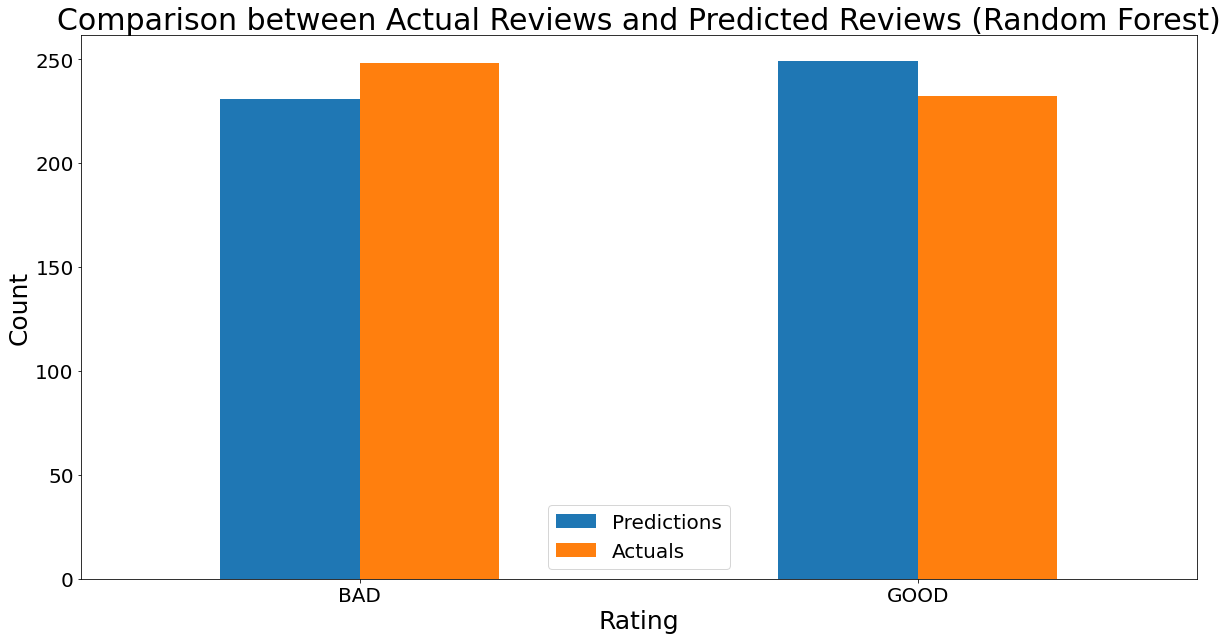

In [36]:
random_forest_df.plot.bar(rot=0, figsize=(20,10))

plt.title('Comparison between Actual Reviews and Predicted Reviews (Random Forest)',fontsize=30)

plt.xlabel('Rating',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('Count',fontsize=25)
plt.yticks(fontsize=20)
plt.legend(fontsize=20);

# K-Nearest Neighbors (KNN)

In [37]:
# # Perform a gridsearch for Random Forest
# # Obtain optimal values of model hyperparameters

# KNN_classifier = KNeighborsClassifier()

# params = {'n_neighbors': [5,15,25], # Number of neighbors
#              'weights': ['uniform','distance']} # Weight function used in prediction

# g_s_KNN = GridSearchCV(KNN_classifier,param_grid=params, n_jobs=-1) # create gridsearch with input params
# grid_result = g_s_KNN.fit(X_train, y_train) # fit gridsearch with training data
# best_params = grid_result.best_params_ # output best params for given data
# best_params

In [38]:
KNN_classifier = KNeighborsClassifier(n_neighbors=25,weights='uniform')
KNN_classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=25)

In [39]:
KNN_predictions = KNN_classifier.predict(X_test)
KNN_predictions

array(['GOOD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'GOOD', 'BAD', 'GOOD',
       'GOOD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'BAD', 'BAD',
       'GOOD', 'BAD', 'BAD', 'GOOD', 'BAD', 'BAD', 'BAD', 'GOOD', 'BAD',
       'GOOD', 'GOOD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'BAD', 'BAD',
       'GOOD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'GOOD', 'GOOD', 'BAD',
       'BAD', 'GOOD', 'BAD', 'GOOD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD',
       'GOOD', 'BAD', 'BAD', 'GOOD', 'BAD', 'GOOD', 'BAD', 'GOOD', 'GOOD',
       'GOOD', 'GOOD', 'GOOD', 'GOOD', 'GOOD', 'BAD', 'GOOD', 'GOOD',
       'GOOD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'GOOD', 'GOOD',
       'GOOD', 'BAD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'BAD',
       'GOOD', 'BAD', 'GOOD', 'BAD', 'GOOD', 'BAD', 'GOOD', 'BAD', 'GOOD',
       'GOOD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'GOOD', 'GOOD',
       'GOOD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'GOOD', 'GOOD',
       'GOOD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'BAD', 'BAD', 'GOOD', 'GOOD',


## Results

### Confusion Matrix

In [40]:
print(confusion_matrix(y_test, KNN_predictions))

[[152  96]
 [ 32 200]]


### Classification Report

In [41]:
print(classification_report(y_test, KNN_predictions))

              precision    recall  f1-score   support

         BAD       0.83      0.61      0.70       248
        GOOD       0.68      0.86      0.76       232

    accuracy                           0.73       480
   macro avg       0.75      0.74      0.73       480
weighted avg       0.75      0.73      0.73       480



### Accuracy Score

In [42]:
print(accuracy_score(y_test, KNN_predictions))

0.7333333333333333


In [43]:
accuracy_results = accuracy_results.append({'Model':'KNN', 'Accuracy':accuracy_score(y_test, KNN_predictions)},ignore_index=True)
accuracy_results

,Model,Accuracy
0,Logistic Regression,0.750000
1,Random Forest,0.789583
2,KNN,0.733333


### Plot Comparison between Actuals and Predicted

In [44]:
predictions_count = dict(Counter(KNN_predictions))
predictions_count_df = pd.DataFrame.from_dict(predictions_count, orient ='index', columns =['Predictions'])

y_test_count = dict(Counter(y_test))
y_test_count_df = pd.DataFrame.from_dict(y_test_count, orient ='index', columns =['Actuals'])

KNN_df = pd.concat([predictions_count_df, y_test_count_df], axis=1).fillna(0)

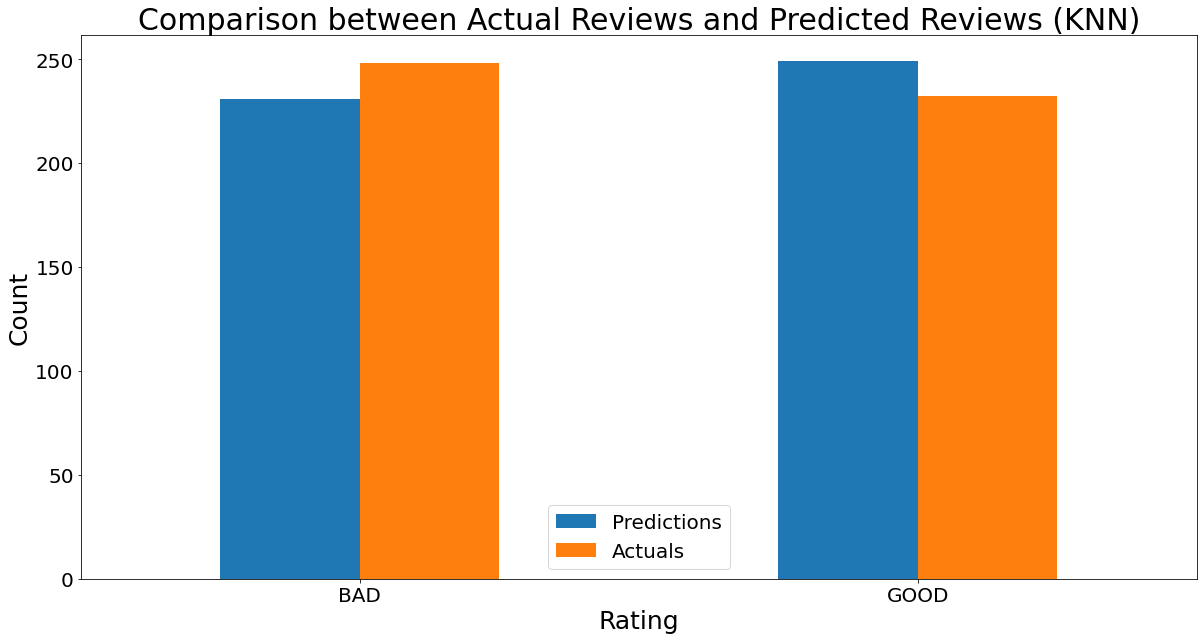

In [45]:
random_forest_df.plot.bar(rot=0, figsize=(20,10))

plt.title('Comparison between Actual Reviews and Predicted Reviews (KNN)',fontsize=30)

plt.xlabel('Rating',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('Count',fontsize=25)
plt.yticks(fontsize=20)
plt.legend(fontsize=20);

# SVM

In [46]:
# # Perform a gridsearch for Random Forest
# # Obtain optimal values of model hyperparameters

# SVM_classifier = SVC()

# params = [{'C': np.logspace(-3, 2, 6), 
#            'gamma': np.logspace(-3, 2, 6)}]

# g_s_SVM = GridSearchCV(SVM_classifier,param_grid=params, n_jobs=-1) # create gridsearch with input params
# grid_result = g_s_SVM.fit(X_train, y_train) # fit gridsearch with training data
# best_params = grid_result.best_params_ # output best params for given data
# best_params

In [47]:
SVM_classifier = SVC(C=100.0, gamma=0.01)
SVM_classifier.fit(X_train, y_train)

SVC(C=100.0, gamma=0.01)

In [48]:
SVM_predictions = SVM_classifier.predict(X_test)
SVM_predictions

array(['BAD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'GOOD', 'BAD', 'GOOD',
       'GOOD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'BAD', 'BAD',
       'GOOD', 'GOOD', 'BAD', 'BAD', 'BAD', 'BAD', 'BAD', 'GOOD', 'BAD',
       'BAD', 'GOOD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'GOOD',
       'BAD', 'GOOD', 'GOOD', 'GOOD', 'BAD', 'GOOD', 'BAD', 'BAD', 'GOOD',
       'BAD', 'BAD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'GOOD', 'BAD',
       'BAD', 'GOOD', 'BAD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'BAD',
       'GOOD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'BAD',
       'BAD', 'GOOD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'BAD',
       'BAD', 'GOOD', 'BAD', 'BAD', 'BAD', 'GOOD', 'BAD', 'BAD', 'BAD',
       'GOOD', 'BAD', 'BAD', 'BAD', 'BAD', 'BAD', 'BAD', 'GOOD', 'GOOD',
       'BAD', 'BAD', 'BAD', 'BAD', 'GOOD', 'BAD', 'GOOD', 'GOOD', 'GOOD',
       'GOOD', 'GOOD', 'GOOD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'BAD',
       'GOOD', 'BAD', 'BAD', 'BAD', 'BAD', 'GOOD', 'GO

## Results

### Confusion Matrix

In [49]:
print(confusion_matrix(y_test, SVM_predictions))

[[202  46]
 [ 51 181]]


### Classification Report

In [50]:
print(classification_report(y_test, SVM_predictions))

              precision    recall  f1-score   support

         BAD       0.80      0.81      0.81       248
        GOOD       0.80      0.78      0.79       232

    accuracy                           0.80       480
   macro avg       0.80      0.80      0.80       480
weighted avg       0.80      0.80      0.80       480



### Accuracy Score

In [51]:
print(accuracy_score(y_test, SVM_predictions))

0.7979166666666667


In [52]:
accuracy_results = accuracy_results.append({'Model':'SVM', 'Accuracy':accuracy_score(y_test, SVM_predictions)},ignore_index=True)
accuracy_results

,Model,Accuracy
0,Logistic Regression,0.750000
1,Random Forest,0.789583
2,KNN,0.733333
3,SVM,0.797917


### Plot Comparison between Actuals and Predicted

In [53]:
predictions_count = dict(Counter(SVM_predictions))
predictions_count_df = pd.DataFrame.from_dict(predictions_count, orient ='index', columns =['Predictions'])

y_test_count = dict(Counter(y_test))
y_test_count_df = pd.DataFrame.from_dict(y_test_count, orient ='index', columns =['Actuals'])

KNN_df = pd.concat([predictions_count_df, y_test_count_df], axis=1).fillna(0)

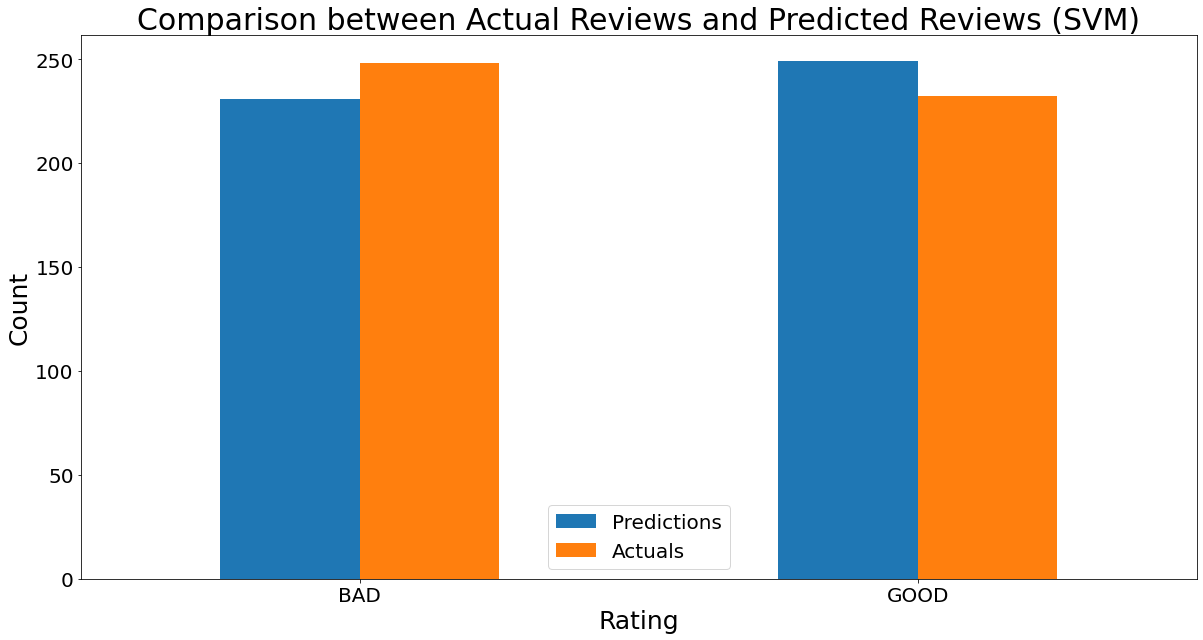

In [54]:
random_forest_df.plot.bar(rot=0, figsize=(20,10))

plt.title('Comparison between Actual Reviews and Predicted Reviews (SVM)',fontsize=30)

plt.xlabel('Rating',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('Count',fontsize=25)
plt.yticks(fontsize=20)
plt.legend(fontsize=20);

# Sentiment Analyzer using NLTK Module Vader

* works well with social media type text
* doesn't require any training data and is constructed using human-curated sentiment lexicon

In [55]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [56]:
def sentiment_analyzer_scores(sentence):
    # polarity_scores: ranging from -1 (most neg) to 1 (most pos)
    score = analyser.polarity_scores(sentence)
    return score # {neg: Negative, neu: Neutral, pos: Positive, compound: Aggregated Score}

In [57]:
def compound_score(text):
    comp=sentiment_analyzer_scores(text)
    return comp['compound'] # returns the compound score from the dictionary

In [58]:
# applying on the reviews column to get the score
final_df['sentiment_score'] = final_df['review_description'].apply(lambda x:compound_score(x))

In [59]:
final_df.head()

,asin_id,name,price,avg_rating,no_of_ratings,review_id,review_title,review_description,user_rating,cleaned_title,cleaned_reviews,new_rating,sentiment_score
0,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1OSPWS88F2CUZ,DO NOT BUY!!!,I would give this zero stars if I could! If ...,1.0,buy,would give zero stars could youre original sor...,BAD,0.8548
1,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1DCFJ8VYSN17B,Is this the millennial version?,This is not the original sorry game. It only...,1.0,millennial version,original sorry game pawns per team instead tr...,BAD,-0.4873
2,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1V07N4GXA7RSL,Wimp and Crybaby Edition,We bought this to replace our old Sorry game...,1.0,wimp crybaby edition,bought replace old sorry game falling apart w...,BAD,0.2885
3,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R2Z262NZDEU2EY,NOT the original/regular Sorry!,Be warned that this is not the sorry you gre...,2.0,originalregular sorry,warned sorry grew three tokens per player rule...,BAD,0.8726
4,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,RG3XIFV1PUX9Y,"Not the classic by a long shot, but okay.","Definitely not the classic game, with only 3...",4.0,classic long shot okay,definitely classic game pawns cards instead d...,GOOD,0.9565


In [60]:
def sentiment_category(score):
    if score >= 0.2:
        return 'GOOD'
    else:
        return 'BAD'

In [61]:
final_df['sentiment_score_rating'] = final_df['sentiment_score'].apply(lambda x: sentiment_category(x))

In [62]:
final_df.head()

,asin_id,name,price,avg_rating,no_of_ratings,review_id,review_title,review_description,user_rating,cleaned_title,cleaned_reviews,new_rating,sentiment_score,sentiment_score_rating
0,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1OSPWS88F2CUZ,DO NOT BUY!!!,I would give this zero stars if I could! If ...,1.0,buy,would give zero stars could youre original sor...,BAD,0.8548,GOOD
1,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1DCFJ8VYSN17B,Is this the millennial version?,This is not the original sorry game. It only...,1.0,millennial version,original sorry game pawns per team instead tr...,BAD,-0.4873,BAD
2,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1V07N4GXA7RSL,Wimp and Crybaby Edition,We bought this to replace our old Sorry game...,1.0,wimp crybaby edition,bought replace old sorry game falling apart w...,BAD,0.2885,GOOD
3,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R2Z262NZDEU2EY,NOT the original/regular Sorry!,Be warned that this is not the sorry you gre...,2.0,originalregular sorry,warned sorry grew three tokens per player rule...,BAD,0.8726,GOOD
4,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,RG3XIFV1PUX9Y,"Not the classic by a long shot, but okay.","Definitely not the classic game, with only 3...",4.0,classic long shot okay,definitely classic game pawns cards instead d...,GOOD,0.9565,GOOD


## Results

### Confusion Matrix

In [63]:
cnf_matrix = confusion_matrix(final_df['new_rating'],final_df['sentiment_score_rating'])
cnf_matrix

array([[ 546,  742],
       [ 232, 3967]])

### Classification Report

In [64]:
print(classification_report(final_df['new_rating'],final_df['sentiment_score_rating']))

              precision    recall  f1-score   support

         BAD       0.70      0.42      0.53      1288
        GOOD       0.84      0.94      0.89      4199

    accuracy                           0.82      5487
   macro avg       0.77      0.68      0.71      5487
weighted avg       0.81      0.82      0.81      5487



### Accuracy Score

In [65]:
from sklearn.metrics import accuracy_score
vader_accuracy_score = accuracy_score(final_df['new_rating'],final_df['sentiment_score_rating'])
vader_accuracy_score

0.822489520685256

In [66]:
accuracy_results = accuracy_results.append({'Model':'Vader', 'Accuracy':vader_accuracy_score},ignore_index=True)
accuracy_results

,Model,Accuracy
0,Logistic Regression,0.750000
1,Random Forest,0.789583
2,KNN,0.733333
3,SVM,0.797917
4,Vader,0.822490


### Plot Comparison between Actuals and Predicted

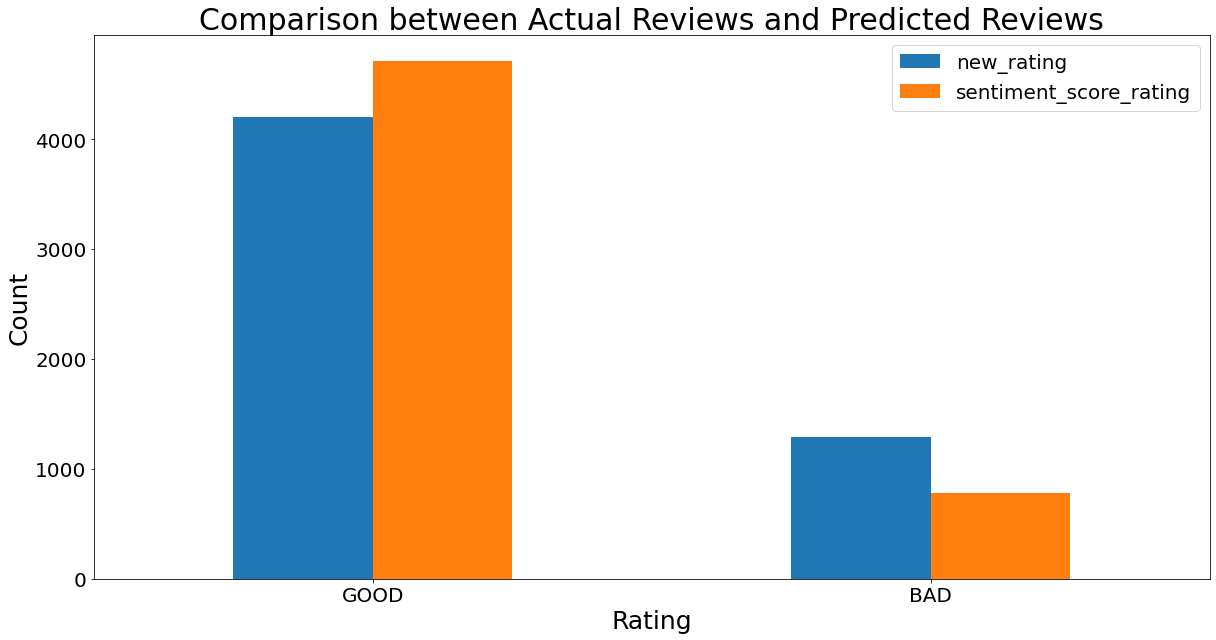

In [67]:
review_rating_counts = final_df['new_rating'].value_counts()
sentiment_score_rating_counts = final_df['sentiment_score_rating'].value_counts()

review_df = pd.concat([review_rating_counts, sentiment_score_rating_counts], axis=1)

review_df.plot.bar(rot=0, figsize=(20,10))

plt.title('Comparison between Actual Reviews and Predicted Reviews',fontsize=30)

plt.xlabel('Rating',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('Count',fontsize=25)
plt.yticks(fontsize=20)
plt.legend(fontsize=20);

# Predictive Accuracy Results

In [68]:
accuracy_results

,Model,Accuracy
0,Logistic Regression,0.750000
1,Random Forest,0.789583
2,KNN,0.733333
3,SVM,0.797917
4,Vader,0.822490


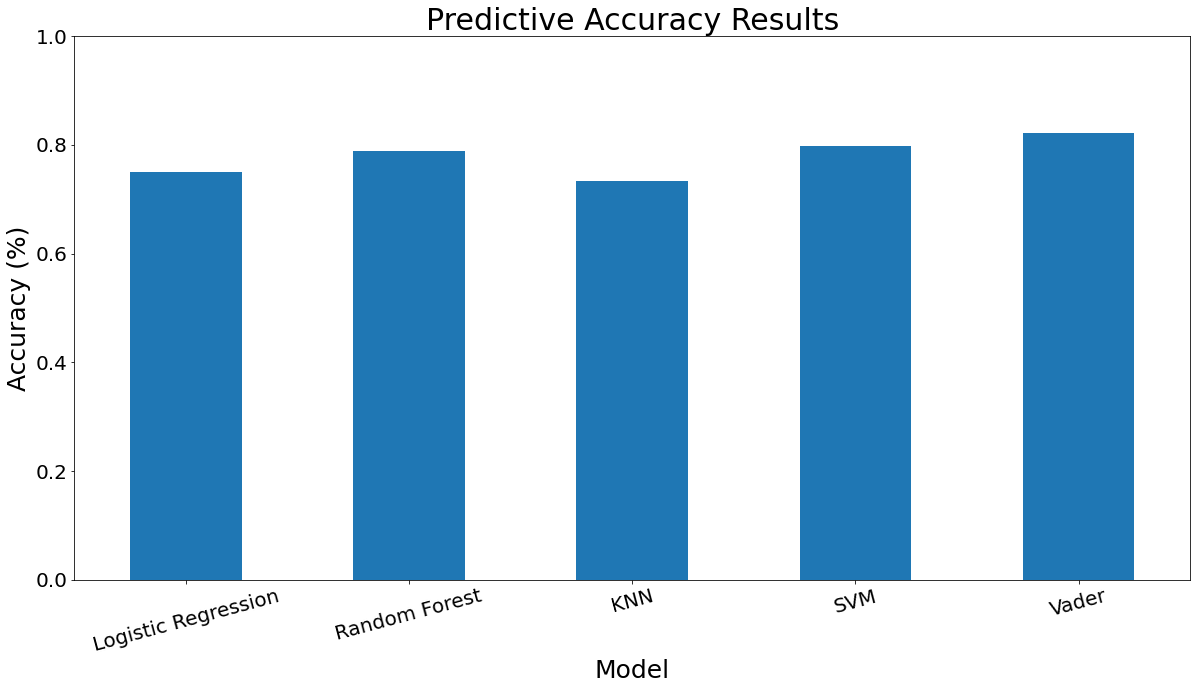

In [69]:
accuracy_results.plot.bar('Model','Accuracy', rot=15, figsize=(20,10))

plt.title('Predictive Accuracy Results',fontsize=30)
plt.xlabel('Model',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('Accuracy (%)',fontsize=25)
plt.yticks(fontsize=20)
plt.ylim(0, 1.0)

plt.legend().remove();